In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from celmech.nbody_simulation_utilities import set_timestep,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
import rebound as rb
from os.path import isfile
from sympy import init_printing
from celmech.disturbing_function import get_fg_coeffs
from celmech.secular import LaplaceLagrangeSystem
from celmech.disturbing_function import laplace_b as b


def get_Z(res, i1, i2, j, k):
    f,g = get_fg_coeffs(j,k)
    h1 = res['e'][i1-1]*np.sin(res['pomega'][i1-1])
    k1 = res['e'][i1-1]*np.cos(res['pomega'][i1-1])
    h2 = res['e'][i2-1]*np.sin(res['pomega'][i2-1])
    k2 = res['e'][i2-1]*np.cos(res['pomega'][i2-1])
    Zx = (f*k1+g*k2)/np.sqrt(f**2+g**2)
    Zy = (f*h1+g*h2)/np.sqrt(f**2+g**2)
    Z = np.sqrt(Zx**2 + Zy**2)
    return Z

def get_Zcom(res, i1, i2, j, k, ps):
    alpha = ps[i1].a/ps[i2].a
    denom = ps[i1].m + alpha**(1/3)*ps[i2].m
    h1 = res['e'][i1-1]*np.sin(res['pomega'][i1-1])
    k1 = res['e'][i1-1]*np.cos(res['pomega'][i1-1])
    h2 = res['e'][i2-1]*np.sin(res['pomega'][i2-1])
    k2 = res['e'][i2-1]*np.cos(res['pomega'][i2-1])
    rx = ps[i1].m*k1 + ps[i2].m*alpha**(-1/6)*k2
    ry = ps[i1].m*h1 + ps[i2].m*alpha**(-1/6)*h2
    r = np.sqrt(rx**2 + ry**2)
    return r/denom

init_printing()

# Jup Saturn Murray and Dermott test

In [2]:
sim = rb.Simulation()
sim.G = 4*np.pi**2
sim.add(m=1)
sim.add(m=9.54786e-4, a=5.202545, e=0.0474622, pomega=13.983865*np.pi/180, inc=1.30667*np.pi/180, Omega=100.0381*np.pi/180)
sim.add(m=2.85837e-4, a=9.554841, e=0.0575481, pomega=88.719425*np.pi/180, inc=2.48795*np.pi/180, Omega=113.1334*np.pi/180)
sim.move_to_com()

# Frequencies match Murray & Dermott

In [3]:
lsys = LaplaceLagrangeSystem.from_Simulation(sim)
lsys.eccentricity_eigenvalues()*180/np.pi

array([-0.00605659, -0.00096033])

### Set up `rebound` simulation

In [4]:
try:
    sa = rb.SimulationArchive('sa_laplace_lagrange_near_res.bin')
except:
    j=5
    k=2
    np.random.seed(1)
    sim = rb.Simulation()
    sim.add(m=1)
    m = 1e-4
    ec = 2*k/(3*j)
    e = 0.03
    da = np.sqrt(16/3*m*(e/ec)**3)
    print(ec, da)
    sim.add(m=m/2, a=1, e=0.05, M=1.5)
    sim.add(m=m/2, a=(j/(j-k))**(2/3)+3.5*da, e=0.05+e, M=-2)
    sim.integrator = 'whfast'
    set_timestep(sim,sim.particles[1].P/20)
    sim.ri_whfast.safe_mode = 0
    sim.move_to_com()

    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    eigvals = lsys.eccentricity_eigenvalues()
    Tsec = np.min(np.abs(2 * np.pi / eigvals))
    sim.automateSimulationArchive('sa_laplace_lagrange_near_res.bin',interval=Tsec/2048,deletefile=True)
    sim.integrate(10*Tsec)

### Set up Laplace-Lagrange secular system corresponding to the `rebound` simulation

In [5]:
nb_results = get_simarchive_integration_results(sa)
sim = sa[0]
lsys = LaplaceLagrangeSystem.from_Simulation(sim)
sec_soln = lsys.secular_solution(nb_results['time'])

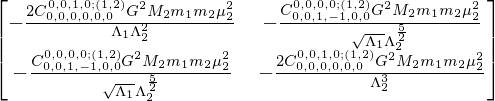

In [6]:
lsys.eccentricity_matrix

In [7]:
lsys.Neccentricity_matrix

array([[-5.08217528e-05,  3.82665833e-05],
       [ 3.82665833e-05, -4.28200166e-05]])

In [8]:
lsys.eccentricity_eigenvalues()

array([-8.52960499e-05, -8.34571948e-06])

# The Laplace Lagrange code uses 

$\kappa$ = sqrt(2)x* = $\sqrt{2\Gamma}\cos(\gamma_i)$

$\eta$ = $\sqrt{2\Gamma}\sin(\gamma_i)$

The f2 and f10 coefficients in Hadden19 have an extra factor of 2 normalization in how he defines Rsec. In explicit Laplace coefficients, should have

$R_{sec} = -\frac{Gm_1m_2}{a_{20}} z^* \cdot M \cdot z$, with

$M = \frac{1}{4}\alpha\begin{pmatrix}
b_{3/2}^{1}(\alpha) & -b_{3/2}^{2}(\alpha) \\
-b_{3/2}^{2}(\alpha) & b_{3/2}^{1}(\alpha)
\end{pmatrix}$

$z^* = \begin{pmatrix}
\frac{1}{\sqrt{\Lambda_{10}}} & 0 \\
0 & \frac{1}{\sqrt{\Lambda_{20}}}
\end{pmatrix}\cdot\begin{pmatrix}\kappa \\ \eta\end{pmatrix}$

$R_{sec} = -\frac{Gm_1m_2}{a_{20}} \begin{pmatrix}\kappa & \eta\end{pmatrix} \cdot A \cdot \begin{pmatrix}\kappa^* \\ \eta^*\end{pmatrix}$, with

with 

$A = \frac{1}{4}\alpha\begin{pmatrix}
\frac{b_{3/2}^{1}(\alpha)}{\Lambda_{10}} & -\frac{b_{3/2}^{2}(\alpha)}{\sqrt{\Lambda_{10}\Lambda_{20}}} \\
-\frac{b_{3/2}^{2}(\alpha)}{\sqrt{\Lambda_{10}\Lambda_{20}}} & \frac{b_{3/2}^{1}(\alpha)}{\Lambda_{20}}
\end{pmatrix}$

# Check mass parameter epsilon matches paper

In [9]:
ps = sim.particles
L10 = ps[1].m*np.sqrt(sim.G*ps[0].m*ps[1].a)
L20 = ps[2].m*np.sqrt(sim.G*ps[0].m*ps[2].a)
sim.G*ps[1].m*ps[2].m/ps[2].a/ps[2].n/(L10*L20/(L10+L20))

In [10]:
ps[1].m + np.sqrt(ps[2].a/ps[1].a)*ps[2].m

# Eccentricity matrix approximately matches celmech above

In [11]:
ps = sa[0].particles
alpha = ps[1].a/ps[2].a
L10 = ps[1].m*np.sqrt(sim.G*ps[0].m*ps[1].a)
L20 = ps[2].m*np.sqrt(sim.G*ps[0].m*ps[2].a)
A = -sim.G*ps[1].m*ps[2].m/ps[2].a*alpha/4*np.array([[b(1.5, 1, 0, alpha)/L10, -b(1.5, 2, 0, alpha)/np.sqrt(L10*L20)], [-b(1.5, 2, 0, alpha)/np.sqrt(L10*L20), b(1.5, 1, 0, alpha)/L20]])
A

array([[-5.07978548e-05,  3.82453657e-05],
       [ 3.82453657e-05, -4.27981659e-05]])

In [12]:
vals,T = np.linalg.eigh(A)
freqs = np.diag(np.diag(vals))
freqs

array([-8.52519666e-05, -8.34405412e-06])

In [13]:
T.T @ A @ T

array([[-8.52519666e-05,  1.27682919e-21],
       [-3.55335511e-21, -8.34405412e-06]])

In [14]:
kappa0 = sec_soln['kappa'][:,0]#/res['Lr']**(1/2)
eta0 = sec_soln['eta'][:,0]#/res['Lr']**(1/2)

In [15]:
H0 = T.T @ eta0
K0 = T.T @ kappa0

In [16]:
t1 = nb_results['time']#-res['time']*ps[2].n*np.exp(1)
cos_vals = np.array([np.cos(freq * t1) for freq in freqs]).T
sin_vals = np.array([np.sin( freq * t1) for freq in freqs]).T
K = K0 * cos_vals - H0 * sin_vals    
H = K0 * sin_vals + H0 * cos_vals
eta = np.transpose(T @ H.T).T# * res['Lr']**(1/2)
kappa = np.transpose(T @ K.T).T# * res['Lr']**(1/2)

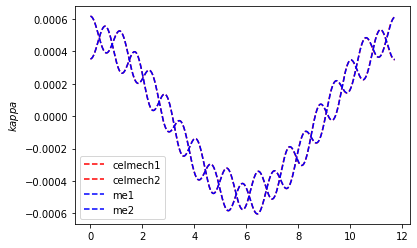

In [17]:
fig,ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
ax.plot(Time,sec_soln['kappa'][0],color='r',ls='--', label='celmech1')  
ax.plot(Time,sec_soln['kappa'][1],color='r',ls='--', label='celmech2')  
ax.plot(Time,kappa[0],color='b',ls='--', label='me1')  
ax.plot(Time,kappa[1],color='b',ls='--', label='me2')  

ax.set_ylabel('$kappa$')
ax.legend()

# Generalized Variables

In [18]:
def LLsoln(M, Gx0, Gy0, times):
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    freqs = np.diag(np.diag(vals))

    Ax0 = T.T @ Gx0
    Ay0 = T.T @ Gy0
    
    cos_vals = np.array([np.cos(freq * times) for freq in freqs]).T
    sin_vals = np.array([np.sin( freq * times) for freq in freqs]).T
    Ax = Ax0 * cos_vals - Ay0 * sin_vals    
    Ay = Ax0 * sin_vals + Ay0 * cos_vals
    Gx = np.transpose(T @ Ax.T).T
    Gy = np.transpose(T @ Ay.T).T
    
    return Gx, Gy

In [19]:
Gx0 = sec_soln['kappa'][:,0]
Gy0 = sec_soln['eta'][:,0]

ps = sa[0].particles
alpha = ps[1].a/ps[2].a
L10 = ps[1].m*np.sqrt(sim.G*ps[0].m*ps[1].a)
L20 = ps[2].m*np.sqrt(sim.G*ps[0].m*ps[2].a)
M = -sim.G*ps[1].m*ps[2].m/ps[2].a*alpha/4*np.array([[b(1.5, 1, 0, alpha)/L10, -b(1.5, 2, 0, alpha)/np.sqrt(L10*L20)], [-b(1.5, 2, 0, alpha)/np.sqrt(L10*L20), b(1.5, 1, 0, alpha)/L20]])

Gx, Gy = LLsoln(M, Gx0, Gy0, nb_results['time'])

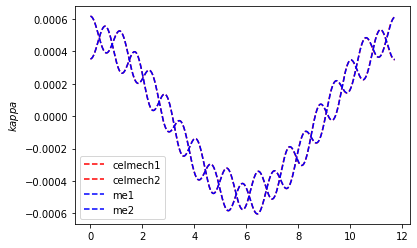

In [20]:
fig,ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
ax.plot(Time,sec_soln['kappa'][0],color='r',ls='--', label='celmech1')  
ax.plot(Time,sec_soln['kappa'][1],color='r',ls='--', label='celmech2')  
ax.plot(Time,Gx[0],color='b',ls='--', label='me1')  
ax.plot(Time,Gx[1],color='b',ls='--', label='me2')  

ax.set_ylabel('$kappa$')
ax.legend()

# Rotated Variables

In [21]:
def rotate(res, sim): # always rotates index 1 and 2 planets
    ps = sim.particles
    res['Lambda'] = np.array([p.m * np.sqrt(sim.G * sim.particles[0].m) for p in sim.particles[1:sim.N_real]]).reshape(-1,1) * np.sqrt(res['a'])
    res['Gamma'] = res['Lambda'] * (1 - np.sqrt(1 - res['e']**2))
    
    res['alpha'] = ps[1].a/ps[2].a
    res['L0'] = res['Lambda'][:,0]
    res['L10'] = res['L0'][0]
    res['L20'] = res['L0'][1]
    res['L12'] = res['L10'] + res['L20']
    res['Lr'] = res['L10']*res['L20']/res['L12']
    res['psi'] = np.pi + np.arcsin(np.sqrt(res['L10']/res['L12']))
    res['R'] = np.identity(res['Lambda'].shape[0]) # Nplanets x Nplanets rotation matrix
    # Only rotate the upper left 2x2 matrix with rotation matrix
    res['R'][:2,:2] = np.array([[np.cos(res['psi']), -np.sin(res['psi'])], [np.sin(res['psi']), np.cos(res['psi'])]])
    res['Gammax'] = np.sqrt(2*res['Gamma'])*np.cos(-res['pomega']) # gamma = -pomega
    res['Gammay'] = np.sqrt(2*res['Gamma'])*np.sin(-res['pomega'])
    res['Fx'] = (res['R'] @ res['Gammax']) / res['Lr']**(1/2)
    res['Fy'] = (res['R'] @ res['Gammay']) / res['Lr']**(1/2)
    res['Phi'] = (res['Fx']**2 + res['Fy']**2)/2
    return res

In [22]:
nb_results = rotate(nb_results, sim)
Nplanets = sec_soln['e'].shape[0]
Nout = sec_soln['e'][0].shape[0]
sec_soln['a'] = np.array([[nb_results['a'][i][0]]*Nout for i in range(Nplanets)])
sec_soln = rotate(sec_soln, sim)

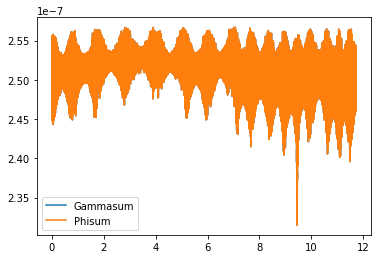

In [23]:
fig, ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
l,=ax.plot(Time,nb_results['Gamma'][0] + nb_results['Gamma'][1], label='Gammasum')
l,=ax.plot(Time,(nb_results['Phi'][0] + nb_results['Phi'][1])*nb_results['Lr'], label='Phisum')
ax.legend()

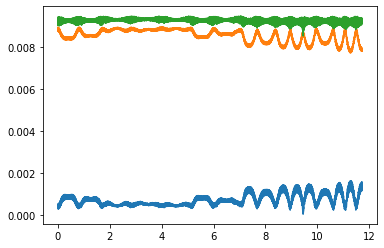

In [24]:
fig, ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
l,=ax.plot(Time,nb_results['Phi'][0])
l,=ax.plot(Time,nb_results['Phi'][1])
l,=ax.plot(Time,nb_results['Phi'][0]+nb_results['Phi'][1])

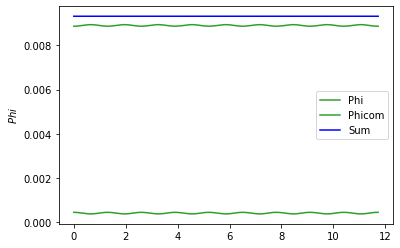

In [25]:
fig,ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
ax.plot(Time,sec_soln['Phi'][0],color=l.get_color(), label='Phi')  
ax.plot(Time,sec_soln['Phi'][1],color=l.get_color(), label='Phicom')  
ax.plot(Time,sec_soln['Phi'][0] + sec_soln['Phi'][1],color='b', label='Sum')  
ax.set_ylabel('$Phi$')
ax.legend()

# My calculation

In [26]:
ps = sa[0].particles
alpha = sec_soln['alpha']
L10 = sec_soln['L10']
L20 = sec_soln['L20']
L12 = sec_soln['L12']
Lr = sec_soln['Lr']
R = sec_soln['R']

In [27]:
eps = (ps[1].m + alpha**(-1/2)*ps[2].m)/ps[0].m
M = -eps*alpha/4*np.array([[b(1.5, 1, 0, alpha)*L20/L12, -b(1.5, 2, 0, alpha)*np.sqrt(L10*L20)/L12], [-b(1.5, 2, 0, alpha)*np.sqrt(L10*L20)/L12, b(1.5, 1, 0, alpha)*L10/L12]])
M = R @ M @ R.T
M

array([[-1.42538156e-04, -1.19798325e-06],
       [-1.19798325e-06, -1.39631719e-05]])

# The L-L matrix for Htilde (My eq 9) is the same as the celmech eccentricity_matrix to within a factor of n2 

Normalizing actions by $\Lambda_r$ cancels out in Hamiltonian. But I think writing M the way I do avoids vanishing at either mass=0

# This is how I can get M in my normalized Hamiltonian from celmech for any number of planets 

Matches matrix above to within mu due to different coordinates (celmech uses canonical heliocentric)

In [28]:
sim = sa[0]
ps = sim.particles
Mnorm = sec_soln['R'] @ lsys.Neccentricity_matrix/ps[2].n @ sec_soln['R'].T
Mnorm

array([[-1.42604755e-04, -1.19569471e-06],
       [-1.19569471e-06, -1.39652412e-05]])

# Check rotated matrix equation (matches above)

In [29]:
d = (b(1.5, 2, 0, alpha)-b(1.5, 1, 0, alpha))/b(1.5, 1, 0, alpha)
M = -eps*alpha*b(1.5, 1, 0, alpha)/4 * np.array([[1 + 2*L10*L20/L12**2*d, d*np.sqrt(L10*L20)/L12**2*(L10-L20)], [d*np.sqrt(L10*L20)/L12**2*(L10-L20), -2*L10*L20/L12**2*d]])
M

array([[-1.42538156e-04, -1.19798325e-06],
       [-1.19798325e-06, -1.39631719e-05]])

In [30]:
d = (b(1.5, 2, 0, alpha)-b(1.5, 1, 0, alpha))/b(1.5, 1, 0, alpha)
prefac = -eps*alpha*b(1.5, 1, 0, alpha)/4
Md = np.array([[2*Lr/L12, np.sqrt(Lr/L12)*(L10-L20)/L12], [np.sqrt(Lr/L12)*(L10-L20)/L12, -2*Lr/L12]])
M = prefac * (np.array([[1,0], [0,0]]) + d*Md)
M

array([[-1.42538156e-04, -1.19798325e-06],
       [-1.19798325e-06, -1.39631719e-05]])

# Need to normalize times correctly

In [31]:
Fx0 = R @ sec_soln['kappa'][:,0]/Lr**(1/2)
Fy0 = R @ sec_soln['eta'][:,0]/Lr**(1/2)
Fx, Fy = LLsoln(M, Fx0, Fy0, nb_results['time']*ps[2].n)
Phi = (Fx[0]**2 + Fy[0]**2)/2

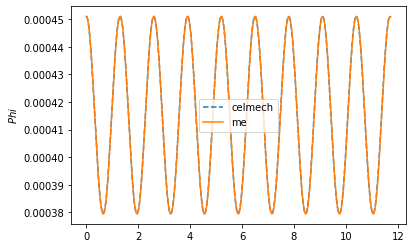

In [33]:
fig,ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
ax.plot(Time,sec_soln['Phi'][0],ls='--', label='celmech')  
ax.plot(Time,Phi, label='me')  
ax.set_ylabel('$Phi$')
ax.legend()

# Max e- value

In van Laerhoven ej = S1*eig1j, S1 = mode amplitude = sqrt(H0[1]**2 + K0[1])**2), eig1j is how much of eigenvector of mode 1 is in planet 1

know eigenvectors from T, and S from H0, K0. Max e = when all modes line up, so emax_j = Sum_i S_i*eigij

In [34]:
def maxG(M, Gx0, Gy0):
    vals,T = np.linalg.eigh(M)
    freqs = np.diag(np.diag(vals))

    Ax0 = T.T @ Gx0
    Ay0 = T.T @ Gy0
    
    A = np.sqrt(Ax0**2 + Ay0**2) # Mode amplitudes (A[0], A[1])
    Gmax = np.abs(T) @ A.T
    return Gmax

In [35]:
Gmax = maxG(M, Fx0, Fy0)
Gmax

array([0.0300331 , 0.13369607])

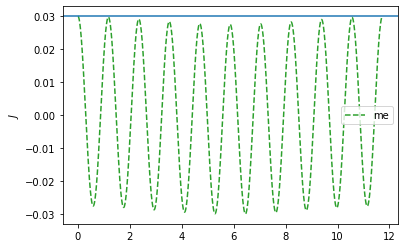

In [36]:
fig,ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
ax.plot(Time,Fx[0],color=l.get_color(),ls='--', label='me')  
ax.axhline(Gmax[0])
ax.set_ylabel('$J$')
ax.legend()

# 3 planets

In [37]:
try:
    sa = rb.SimulationArchive('sa_laplace_lagrange_near_res_3p.bin')
except:
    j=5
    k=2
    np.random.seed(1)
    sim = rb.Simulation()
    sim.add(m=1)
    m = 1e-4
    ec = 2*k/(3*j)
    e = 0.03
    da = np.sqrt(16/3*m*(e/ec)**3)
    print(ec, da)
    sim.add(m=m/2, a=1, e=0.05, M=1.5)
    sim.add(m=m/2, a=(j/(j-k))**(2/3)+3.5*da, e=0.05+e, M=-2)
    alpha = sim.particles[1].a/sim.particles[2].a
    a3 = sim.particles[2].a/alpha
    sim.add(m=m/2, a=a3, e=0.05, M=0)
    sim.integrator = 'whfast'
    set_timestep(sim,sim.particles[1].P/20)
    sim.ri_whfast.safe_mode = 0
    sim.move_to_com()

    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    eigvals = lsys.eccentricity_eigenvalues()
    Tsec = np.min(np.abs(2 * np.pi / eigvals))
    sim.automateSimulationArchive('sa_laplace_lagrange_near_res_3p.bin',interval=Tsec/2048,deletefile=True)
    sim.integrate(10*Tsec)

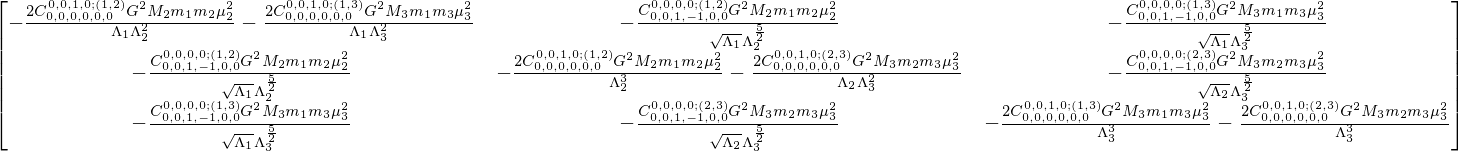

In [38]:
sim = sa[0]
lsys = LaplaceLagrangeSystem.from_Simulation(sim)
lsys.eccentricity_matrix

In [33]:
nb_results = get_simarchive_integration_results(sa)
sim = sa[0]
ps = sim.particles
lsys = LaplaceLagrangeSystem.from_Simulation(sim)
sec_soln = lsys.secular_solution(nb_results['time'])

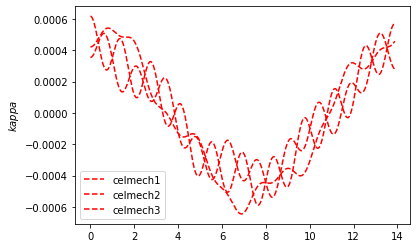

In [40]:
fig,ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
ax.plot(Time,sec_soln['kappa'][0],color='r',ls='--', label='celmech1')  
ax.plot(Time,sec_soln['kappa'][1],color='r',ls='--', label='celmech2')  
ax.plot(Time,sec_soln['kappa'][2],color='r',ls='--', label='celmech3')  
ax.set_ylabel('$kappa$')
ax.legend()

In [41]:
nb_results = rotate(nb_results, sim)
Nplanets = sec_soln['e'].shape[0]
Nout = sec_soln['e'][0].shape[0]
sec_soln['a'] = np.array([[nb_results['a'][i][0]]*Nout for i in range(Nplanets)])
sec_soln = rotate(sec_soln, sim)

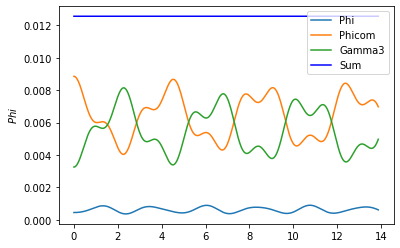

In [42]:
fig,ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
ax.plot(Time,sec_soln['Phi'][0], label='Phi')  
ax.plot(Time,sec_soln['Phi'][1], label='Phicom')  
ax.plot(Time,sec_soln['Phi'][2], label='Gamma3')  

ax.plot(Time,sec_soln['Phi'][0] + sec_soln['Phi'][1] + sec_soln['Phi'][2],color='b', label='Sum')  
ax.set_ylabel('$Phi$')
ax.legend()

# This is how to take the celmech eccentricity matrix and convert to the matrix for our normalized Hamiltonian

In [41]:
Mnorm = sec_soln['R'] @ lsys.Neccentricity_matrix/ps[2].n @ sec_soln['R'].T
Fx0 = sec_soln['R'] @ sec_soln['kappa'][:,0]/sec_soln['Lr']**(1/2)
Fy0 = sec_soln['R'] @ sec_soln['eta'][:,0]/sec_soln['Lr']**(1/2)
Fx, Fy = LLsoln(Mnorm, Fx0, Fy0, nb_results['time']*ps[2].n)
Phi = (Fx[0]**2 + Fy[0]**2)/2

In [42]:
Gmax = maxG(Mnorm, Fx0, Fy0)
Gmax

array([0.04244703, 0.13306569, 0.12800827])

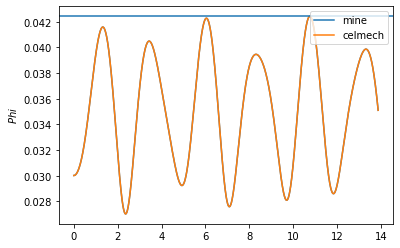

In [43]:
emx = sec_soln['kappa'][1]/np.sqrt(sec_soln['L0'][1])-sec_soln['kappa'][0]/np.sqrt(sec_soln['L0'][0])
emy = sec_soln['eta'][1]/np.sqrt(sec_soln['L0'][1])-sec_soln['eta'][0]/np.sqrt(sec_soln['L0'][0])
em = np.sqrt(emx**2 + emy**2)

fig,ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
ax.plot(Time,np.sqrt(2*Phi), label='mine')  
ax.plot(Time,em, label='celmech')  
ax.axhline(Gmax[0])
ax.set_ylabel('$Phi$')
ax.legend()

# Function to calc eminus_max all in one place from REBOUND sim

In [97]:
def eminus_max(sim):
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    ps = sim.particles
    res = {}
    res['Lambda'] = np.array([p.m * np.sqrt(sim.G * sim.particles[0].m * p.a) for p in ps[1:sim.N_real]])
    res['Gamma'] = res['Lambda'] * np.array([1 - np.sqrt(1 - p.e**2) for p in ps[1:sim.N_real]])
    res['alpha'] = ps[1].a/ps[2].a
    res['L0'] = res['Lambda'][:]
    res['L10'] = res['L0'][0]
    res['L20'] = res['L0'][1]
    res['L12'] = res['L10'] + res['L20']
    res['Lr'] = res['L10']*res['L20']/res['L12']
    res['psi'] = np.pi + np.arcsin(np.sqrt(res['L10']/res['L12']))
    res['R'] = np.identity(res['Lambda'].shape[0]) # Nplanets x Nplanets rotation matrix
    # Only rotate the upper left 2x2 matrix with rotation matrix
    res['R'][:2,:2] = np.array([[np.cos(res['psi']), -np.sin(res['psi'])], [np.sin(res['psi']), np.cos(res['psi'])]])
    res['Gammax'] = np.sqrt(2*res['Gamma'])*np.cos([-p.pomega for p in ps[1:sim.N_real]]) # gamma = -pomega
    res['Gammay'] = np.sqrt(2*res['Gamma'])*np.sin([-p.pomega for p in ps[1:sim.N_real]])
    
    Mnorm = res['R'] @ lsys.Neccentricity_matrix/ps[2].n @ res['R'].T
    Fx0 = res['R'] @ res['Gammax']/res['Lr']**(1/2)
    Fy0 = res['R'] @ res['Gammay']/res['Lr']**(1/2)
    
    vals,T = np.linalg.eigh(Mnorm)
    freqs = np.diag(np.diag(vals))
    
    Ax0 = T.T @ Fx0
    Ay0 = T.T @ Fy0
    A = np.sqrt(Ax0**2 + Ay0**2) # Mode amplitudes (A[0], A[1])
    Fmax = np.abs(T) @ A.T
    return Fmax

In [98]:
eminus_max(sim)

array([0.04254903, 0.13313526, 0.12808682])

In [103]:
eminus_max(sim, i1=2, i2=3)

In [833]:
def sec(sim, i1, i2):
    if i1 > i2:
        raise AttributeEror("i2 must be exterior body")
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    ps = sim.particles
    res = {}
    res['Lambda'] = np.array([p.m * np.sqrt(sim.G * sim.particles[0].m * p.a) for p in ps[1:sim.N_real]])
    res['Gamma'] = res['Lambda'] * np.array([1 - np.sqrt(1 - p.e**2) for p in ps[1:sim.N_real]])
    res['L10'] = res['Lambda'][i1-1]
    res['L20'] = res['Lambda'][i2-1]
    res['L12'] = res['L10'] + res['L20']
    res['Lr'] = res['L10']*res['L20']/res['L12']
    res['psi'] = np.pi + np.arcsin(np.sqrt(res['L10']/res['L12']))
    res['R'] = np.identity(res['Lambda'].shape[0]) # Nplanets x Nplanets rotation matrix
    # Only rotate the 2x2 submatrix corresponding to i1 and i2 with rotation matrix
    res['R'][np.ix_([i1-1,i2-1],[i1-1, i2-1])] = np.array([[np.cos(res['psi']), -np.sin(res['psi'])], [np.sin(res['psi']), np.cos(res['psi'])]])
    res['Gammax'] = np.sqrt(2*res['Gamma'])*np.cos([-p.pomega for p in ps[1:sim.N_real]]) # gamma = -pomega
    res['Gammay'] = np.sqrt(2*res['Gamma'])*np.sin([-p.pomega for p in ps[1:sim.N_real]])
    res['M'] = lsys.Neccentricity_matrix # no longer normalized
    
    return res

def eminus_max(sim, i1, i2):
    secres = sec(sim, i1, i2)
    
    vals,T = np.linalg.eigh(secres['R'] @ secres['M'] @ secres['R'].T)
    freqs = np.diag(np.diag(vals))

    Fx0 = secres['R'] @ secres['Gammax']/secres['Lr']**(1/2)
    Fy0 = secres['R'] @ secres['Gammay']/secres['Lr']**(1/2)
    
    Ax0 = T.T @ Fx0
    Ay0 = T.T @ Fy0
    A = np.sqrt(Ax0**2 + Ay0**2) # Mode amplitudes (A[0], A[1], ... A[N-1])
    Fmax = np.abs(T) @ A.T
    emax = Fmax[i1-1]
    
    return emax

def LLsoln(M, Gx0, Gy0, times):
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    freqs = np.diag(np.diag(vals))
    Ax0 = T.T @ Gx0
    Ay0 = T.T @ Gy0
    print(Ax0)
    print(Ay0)
    
    cos_vals = np.array([np.cos(freq * times) for freq in freqs]).T
    sin_vals = np.array([np.sin( freq * times) for freq in freqs]).T
    Ax = Ax0 * cos_vals - Ay0 * sin_vals    
    Ay = Ax0 * sin_vals + Ay0 * cos_vals
    Gx = np.transpose(T @ Ax.T).T
    Gy = np.transpose(T @ Ay.T).T
    
    return Gx, Gy

def LLeminus(sim, times, i1, i2):
    secres = sec(sim, i1, i2)
    Gx, Gy = LLsoln(secres['M'], secres['Gammax'], secres['Gammay'], times)
    Fx = secres['R'] @ Gx/secres['Lr']**(1/2)
    Fy = secres['R'] @ Gy/secres['Lr']**(1/2)
    eminus = np.sqrt(Fx[i1-1]**2 + Fy[i1-1]**2) # eminus is always in the i1 slot
    return eminus

# Initialize in one secular mode

In [34]:
P12**(-2/3)

NameError: name 'P12' is not defined

In [226]:
P3**(2/3)

In [35]:
mu=1e-4
P3 = 2.0328
P12 = 1/1.38
etilde = 0.1

ec = 1 - P12**(2/3)
e = etilde*ec
    
sim = rb.Simulation()
sim.add(m=1)
sim.add(m=mu/3, P=1, e=0.0, M=np.random.random()*2*np.pi)
sim.add(m=mu/3, P=1/P12, e=0.0, M=np.random.random()*2*np.pi)
sim.add(m=mu/3, P=P3, e=0.0, M=np.random.random()*2*np.pi)
sim.move_to_com()

lsys = LaplaceLagrangeSystem.from_Simulation(sim)
M = lsys.Neccentricity_matrix
M*2/M[1,1]

array([[ 1.67658917, -1.24065063, -0.14844054],
       [-1.24065063,  2.        , -0.57307097],
       [-0.14844054, -0.57307097,  0.79288944]])

In [36]:
eigvals = lsys.eccentricity_eigenvalues()
Tsec = np.abs(2 * np.pi / eigvals)
Tsec

array([ 4717.39041794, 12800.6344877 , 84977.09039032])

In [37]:
L = [p.m*np.sqrt(sim.G*sim.particles[0].m*p.a) for p in sim.particles[1:]]
S = np.array([[1/np.sqrt(L[0]), 0, 0], [0, 1/np.sqrt(L[1]), 0], [0, 0, 1/np.sqrt(L[2])]])
S

array([[235.28237699,   0.        ,   0.        ],
       [  0.        , 222.98467255,   0.        ],
       [  0.        ,   0.        , 209.04408226]])

In [38]:
vals,T = np.linalg.eigh(M)

# R from paper = T.Transpose

Fmax = abs(R.T)*A, so
F1max = abs(first row of R.T) dot A = abs(first row of T) dot A

In [39]:
T.T @ M @ T

array([[-1.33191972e-03, -3.12591572e-19, -1.71584743e-19],
       [-3.61045586e-19, -4.90849521e-04,  5.68519991e-20],
       [-5.85566685e-20,  7.53163774e-20, -7.39397557e-05]])

In [40]:
T

array([[ 0.63142057,  0.57116144, -0.52448324],
       [-0.76155378,  0.32932279, -0.55819561],
       [ 0.14609552, -0.75187839, -0.64291134]])

In [44]:
T@A

array([ 0.63142057, -0.76155378,  0.14609552])

In [47]:
M@(T@A)/np.linalg.norm(M@(T@A))

array([-0.63142057,  0.76155378, -0.14609552])

In [41]:
A = [1,0,0]
v0 = S @ T @ A
v0 /= np.linalg.norm(v0)
v0

array([ 0.65248953, -0.745832  ,  0.13413441])

In [942]:
A = [0, 1, 0]
v1 = S @ T @ A
v1 /= np.linalg.norm(v1)
v1

array([ 0.61220934,  0.33495409, -0.71624401])

In [943]:
A = [0,0,1]
v2 = S @ T @ A
v2 /= np.linalg.norm(v2)
v2

array([-0.55866803, -0.56350914, -0.60856181])

In [944]:
v0+v1

array([ 1.26488282, -0.41076092, -0.58235432])

In [954]:
0.3**(0.5)

In [945]:
e1 = v0[0]*e# + v1[0]*e + v2[0]*e
e2 = v0[1]*e# + v1[1]*e + v2[1]*e
e3 = v0[2]*e# + v1[2]*e + v2[2]*e
#e1 = v2[0]*e + v1[0]*e
#e2 = v2[1]*e + v1[1]*e
#e3 = v2[2]*e + v1[2]*e


sim = rb.Simulation()
sim.add(m=1)
sim.add(m=mu/3, P=1, e=abs(e1), pomega=np.arccos(np.sign(e1)), M=0)
sim.add(m=mu/3, P=1/P12, e=abs(e2), pomega=np.arccos(np.sign(e2)), M=np.pi/2)
sim.add(m=mu/3, P=P3, e=abs(e3), pomega=np.arccos(np.sign(e3)), M=-np.pi/2)
sim.move_to_com()
sim.integrator = "whfast"
sim.dt = sim.particles[1].P/20
sim.collision="direct"
sim.ri_whfast_safe_mode=0
ps = sim.particles
for p in ps[1:]:
    p.r = p.a*(p.m/3)**(1/3)

In [946]:
eigvals= lsys.eccentricity_eigenvalues()
Tsec = np.min(np.abs(2 * np.pi / eigvals))
times = np.linspace(0, 20*Tsec, 1000)
Tsec*20

In [947]:
L = [p.m*np.sqrt(sim.G*sim.particles[0].m*p.a) for p in sim.particles[1:]]
Gx0 = [np.sqrt(p.m*np.sqrt(sim.G*sim.particles[0].m*p.a))*p.e*np.cos(p.pomega) for p in sim.particles[1:]]
Gy0 = np.zeros(3)
Gx, Gy = LLsoln(M, Gx0, Gy0, times)
sec_soln = lsys.secular_solution(times)
emx12 = Gx[1]/np.sqrt(L[1]) - Gx[0]/np.sqrt(L[0])
emy12 = Gy[1]/np.sqrt(L[1]) - Gy[0]/np.sqrt(L[0])
emx23 = Gx[2]/np.sqrt(L[2]) - Gx[1]/np.sqrt(L[1])
emy23 = Gy[2]/np.sqrt(L[2]) - Gy[1]/np.sqrt(L[1])
em12 = np.sqrt(emx12**2 + emy12**2)
em23 = np.sqrt(emx23**2 + emy23**2)
modex = v0[0]*Gx[0]/np.sqrt(L[0]) + v0[1]*Gx[1]/np.sqrt(L[1]) + v0[2]*Gx[2]/np.sqrt(L[2])
modey = v0[0]*Gy[0]/np.sqrt(L[0]) + v0[1]*Gy[1]/np.sqrt(L[1]) + v0[2]*Gy[2]/np.sqrt(L[2])

[ 8.48677496e-05  5.01298207e-19 -4.45999038e-19]
[0. 0. 0.]


In [948]:
ps = sim.particles
Nem12, Nem23, Nmodex, Nmodey = np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000)
for i, time in enumerate(times):
    sim.integrate(time)
    Nemx12 = ps[2].e*np.cos(ps[2].pomega) - ps[1].e*np.cos(ps[1].pomega)
    Nemy12 = ps[2].e*np.sin(ps[2].pomega) - ps[1].e*np.sin(ps[1].pomega)
    Nemx23 = ps[3].e*np.cos(ps[3].pomega) - ps[2].e*np.cos(ps[2].pomega)
    Nemy23 = ps[3].e*np.sin(ps[3].pomega) - ps[2].e*np.sin(ps[2].pomega)
    Nem12[i] = np.sqrt(Nemx12**2 + Nemy12**2)
    Nem23[i] = np.sqrt(Nemx23**2 + Nemy23**2)
    Nmodex[i] = v0[0]*ps[1].e*np.cos(ps[1].pomega) + v0[1]*ps[2].e*np.cos(ps[2].pomega) + v0[2]*ps[3].e*np.cos(ps[3].pomega)
    Nmodey[i] = v0[0]*ps[1].e*np.sin(ps[1].pomega) + v0[1]*ps[2].e*np.sin(ps[2].pomega) + v0[2]*ps[3].e*np.sin(ps[3].pomega)

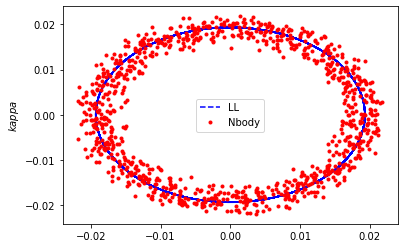

In [949]:
fig,ax = plt.subplots()
#ax.plot(times,sec_soln['kappa'][2],color='r',ls='--', label='celmech1')  
#ax.plot(times,sec_soln['kappa'][1],color='r',ls='--', label='celmech2')  
ax.plot(modex, modey,color='b',ls='--', label='LL')  
ax.plot(Nmodex, Nmodey,'r.', label='Nbody')  

#ax.plot(times,em23,color='b',ls='--', label='me1')  
#ax.plot(times,em12+em23,color='bc',ls='--', label='me1')  


#ax.plot(times,kappa[1],color='b',ls='--', label='me2')  

ax.set_ylabel('$kappa$')
ax.legend()

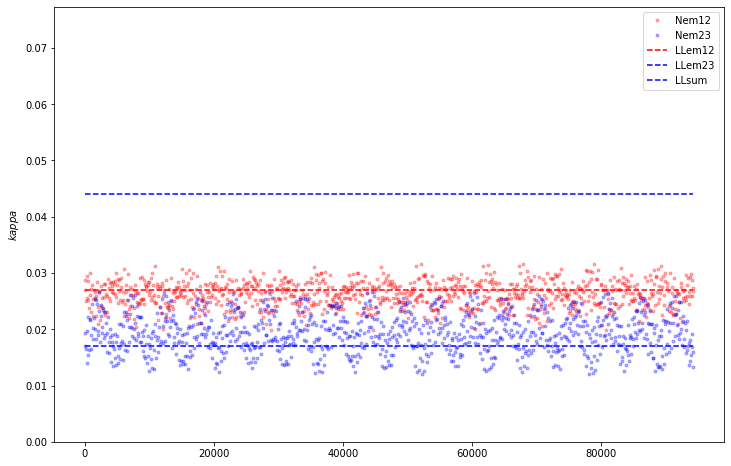

In [950]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(times,Nem12,'r.', alpha=0.3, label='Nem12')  
ax.plot(times,Nem23,'b.', alpha=0.3, label='Nem23')  
ax.plot(times,em12,color='r',ls='--', label='LLem12')  
ax.plot(times,em23,color='b',ls='--', label='LLem23')  
ax.plot(times,em12+em23,color='b',ls='--', label='LLsum')  


ax.set_ylabel('$kappa$')
ax.legend()
ax.set_ylim([0,4*e])

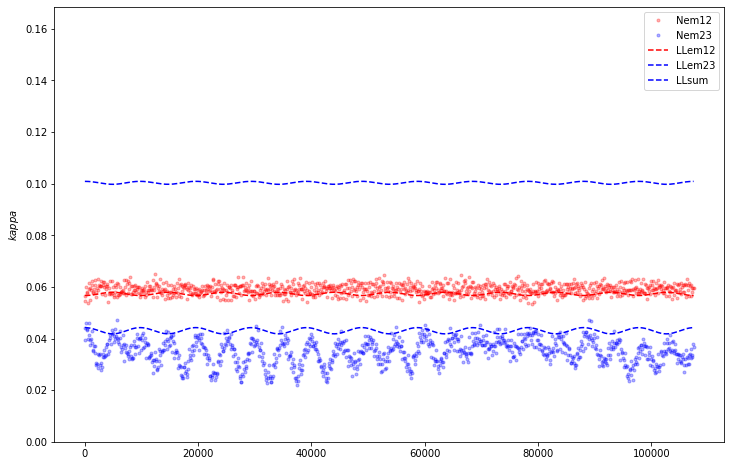

In [774]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(times,Nem12,'r.', alpha=0.3, label='Nem12')  
ax.plot(times,Nem23,'b.', alpha=0.3, label='Nem23')  
ax.plot(times,em12,color='r',ls='--', label='LLem12')  
ax.plot(times,em23,color='b',ls='--', label='LLem23')  
ax.plot(times,em12+em23,color='b',ls='--', label='LLsum')  


ax.set_ylabel('$kappa$')
ax.legend()
ax.set_ylim([0,4*e])

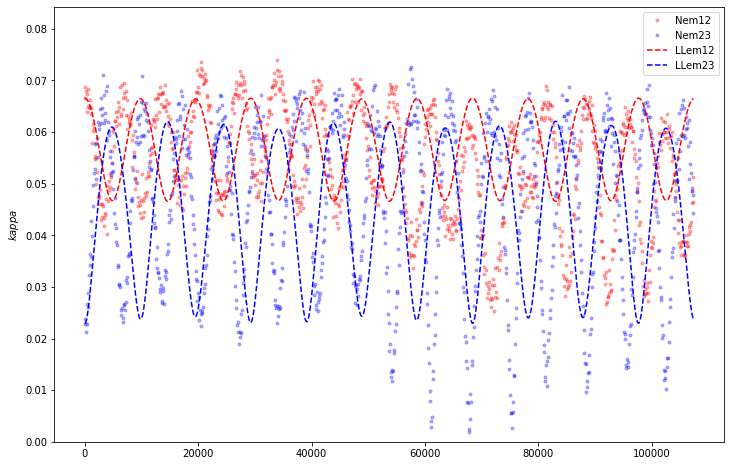

In [716]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(times,Nem12,'r.', alpha=0.3, label='Nem12')  
ax.plot(times,Nem23,'b.', alpha=0.3, label='Nem23')  
ax.plot(times,em12,color='r',ls='--', label='LLem12')  
ax.plot(times,em23,color='b',ls='--', label='LLem23')  

ax.set_ylabel('$kappa$')
ax.legend()
ax.set_ylim([0,4*e])

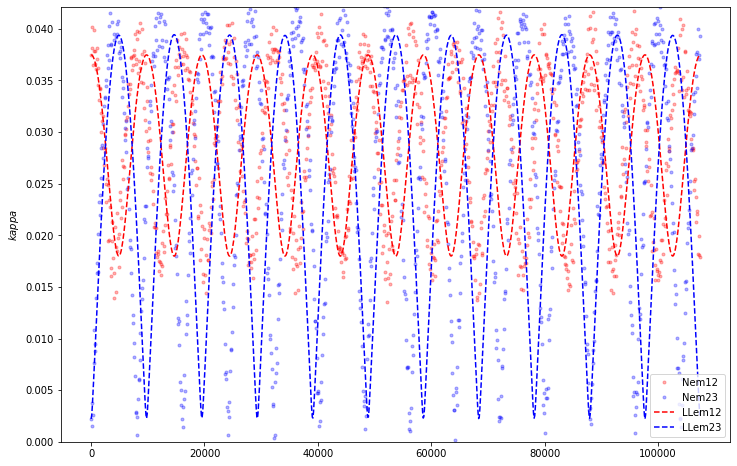

In [676]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(times,Nem12,'r.', alpha=0.3, label='Nem12')  
ax.plot(times,Nem23,'b.', alpha=0.3, label='Nem23')  
ax.plot(times,em12,color='r',ls='--', label='LLem12')  
ax.plot(times,em23,color='b',ls='--', label='LLem23')  

ax.set_ylabel('$kappa$')
ax.legend()
ax.set_ylim([0,2*e])

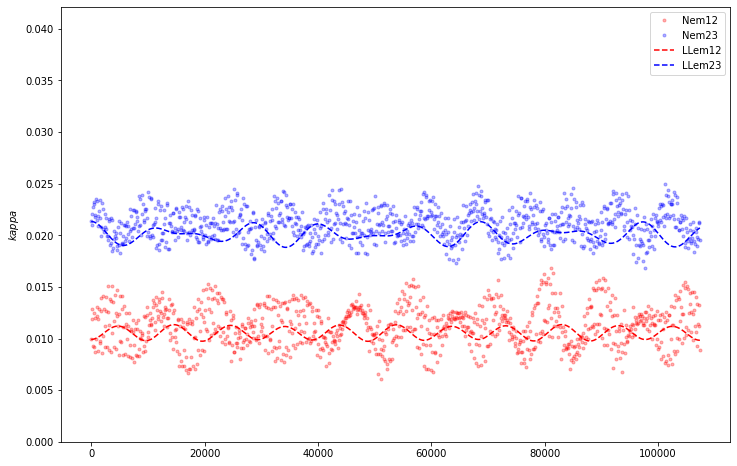

In [638]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(times,Nem12,'r.', alpha=0.3, label='Nem12')  
ax.plot(times,Nem23,'b.', alpha=0.3, label='Nem23')  
ax.plot(times,em12,color='r',ls='--', label='LLem12')  
ax.plot(times,em23,color='b',ls='--', label='LLem23')  

ax.set_ylabel('$kappa$')
ax.legend()
ax.set_ylim([0,2*e])

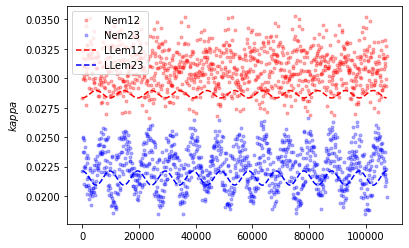

In [434]:
fig,ax = plt.subplots()
ax.plot(times,Nem12,'r.', alpha=0.3, label='Nem12')  
ax.plot(times,Nem23,'b.', alpha=0.3, label='Nem23')  
ax.plot(times,em12,color='r',ls='--', label='LLem12')  
ax.plot(times,em23,color='b',ls='--', label='LLem23')  

ax.set_ylabel('$kappa$')
ax.legend()

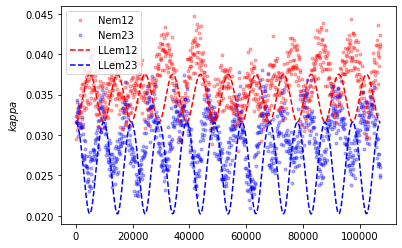

In [384]:
fig,ax = plt.subplots()
ax.plot(times,Nem12,'r.', alpha=0.3, label='Nem12')  
ax.plot(times,Nem23,'b.', alpha=0.3, label='Nem23')  
ax.plot(times,em12,color='r',ls='--', label='LLem12')  
ax.plot(times,em23,color='b',ls='--', label='LLem23')  

ax.set_ylabel('$kappa$')
ax.legend()

In [ ]:
freqs = np.diag(np.diag(vals))

Ax0 = T.T @ Fx0
Ay0 = T.T @ Fy0
A = np.sqrt(Ax0**2 + Ay0**2) # Mode amplitudes (A[0], A[1])
Fmax = np.abs(T) @ A.T

# Bessel function approximation of Laplace coefficients

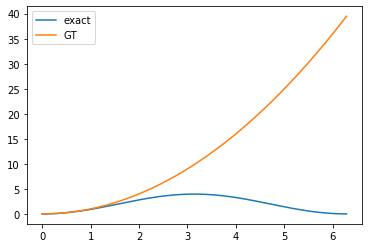

In [66]:
alpha = 0.99
phi = np.linspace(0, 2*np.pi, 1000)
fig, ax = plt.subplots()
ax.plot(phi, 1-2*alpha*np.cos(phi)+alpha**2, label='exact')
ax.plot(phi, (1-alpha)**2 + phi**2, label='GT')
ax.legend()

In [69]:
from sympy import besselk

a = besselk(1, 3).evalf()
a

In [77]:
m=1
alpha=0.999
b(1.5, 1, 0, alpha), 2/np.pi/(1-alpha)*besselk(1, (1-alpha)).evalf()

In [80]:
m=1
b(1.5, m, 0, alpha), 2/np.pi*abs(m)/(1-alpha)*besselk(1, abs(m)*(1-alpha)).evalf()

In [86]:
besselk(1,0.001).evalf()

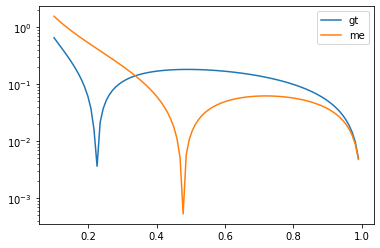

In [133]:
m=1
alphas = np.linspace(0.1, 0.99, 100)
exact = np.array([b(1.5, m, 0, alpha) for alpha in alphas])
gt = np.array([2/np.pi * abs(m)/(1-alpha)*besselk(1, abs(m)*(1-alpha)).evalf() for alpha in alphas])
me = np.array([2/np.pi/(1-alpha)**2 for alpha in alphas])
fig, ax = plt.subplots()
ax.plot(alphas, np.abs((exact-gt)/exact), label='gt')
ax.plot(alphas, np.abs((exact-me)/exact), label='me')
ax.set_yscale('log')
ax.legend()

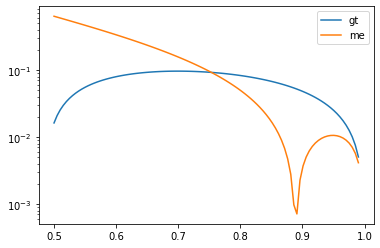

In [132]:
m=2
alphas = np.linspace(0.5, 0.99, 100)
exact = np.array([b(1.5, m, 0, alpha) for alpha in alphas])
gt = np.array([2/np.pi * abs(m)/(1-alpha)*besselk(1, abs(m)*(1-alpha)).evalf() for alpha in alphas])
me = np.array([2/np.pi/(1-alpha)**2 for alpha in alphas])
fig, ax = plt.subplots()
ax.plot(alphas, np.abs((exact-gt)/exact), label='gt')
ax.plot(alphas, np.abs((exact-me)/exact), label='me')
ax.set_yscale('log')
ax.legend()

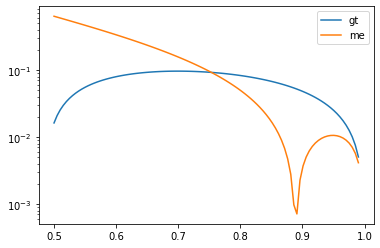

In [132]:
m=2
alphas = np.linspace(0.5, 0.99, 100)
exact = np.array([b(1.5, m, 0, alpha) for alpha in alphas])
gt = np.array([2/np.pi * abs(m)/(1-alpha)*besselk(1, abs(m)*(1-alpha)).evalf() for alpha in alphas])
me = np.array([2/np.pi/(1-alpha)**2 for alpha in alphas])
fig, ax = plt.subplots()
ax.plot(alphas, np.abs((exact-gt)/exact), label='gt')
ax.plot(alphas, np.abs((exact-me)/exact), label='me')
ax.set_yscale('log')
ax.legend()

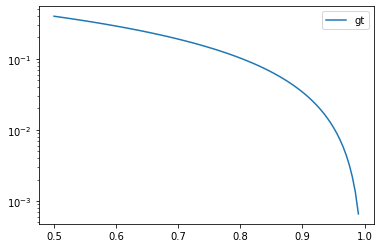

In [94]:
m=1
alphas = np.linspace(0.5, 0.99, 100)
m1 = np.array([b(1.5, 1, 0, alpha) for alpha in alphas])
m2 = np.array([b(1.5, 2, 0, alpha) for alpha in alphas])
fig, ax = plt.subplots()
ax.plot(alphas, np.abs((m1-m2)/m1), label='gt')
#ax.plot(alphas, m2, label='me')
ax.set_yscale('log')
ax.legend()

In [103]:
gamma = 0.57721

In [104]:
besselk(0, 0.1).evalf()

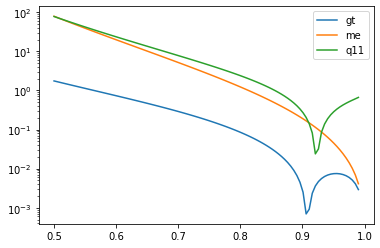

In [127]:
m=6
alphas = np.linspace(0.5, 0.99, 100)
exact = np.array([b(0.5, m, 0, alpha) for alpha in alphas])
q11 = np.array([0.5*abs(np.log(1-alpha))*np.exp(-m*(1-alpha))])
gt = np.array([2/np.pi*besselk(0, abs(m)*(1-alpha)).evalf() for alpha in alphas])
me = np.array([2/np.pi*(np.log(2/abs(m)/(1-alpha)) - gamma) for alpha in alphas])
fig, ax = plt.subplots()
ax.plot(alphas, np.abs((exact-gt)/exact), label='gt')
ax.plot(alphas, np.abs((exact-me)/exact), label='me')
ax.plot(alphas, np.abs((exact-q11)/exact), label='q11')
ax.set_yscale('log')
ax.legend()

In [115]:
alpha=0.9

In [116]:
b(0.5, m, 0, alpha)

In [117]:
0.5*abs(np.log(1-alpha))*np.exp(-m*(1-alpha))

In [106]:
(np.log(2/0.1)-gamma)

# Next Steps


* Finish writing up 2planet
* Verify 3planet code against celmech
* Write up 3planet


* Make numerical test
* Run with fixed tmax for MEGNO
* Run with multiple of minTsec tmax for MEGNO


* Calculate simple AMD estimate
* plot simple AMD estimate
* plot numerical max e- estimate

## Compare $N$-body solution to the Laplace-Lagrange secular solution

### Secular modes

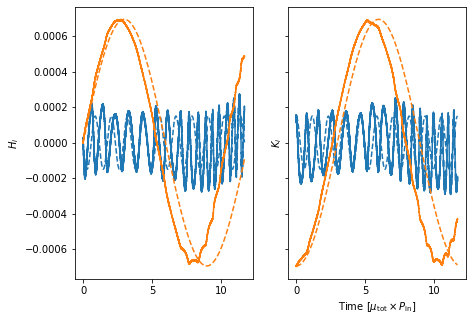

In [523]:
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
T,D = lsys.diagonalize_eccentricity()
nb_results['Lambda'] = np.array([p.m * np.sqrt(lsys.G * p.M) for p in lsys.particles[1:]]).reshape(-1,1) * np.sqrt(nb_results['a'])
nb_results['Gamma'] = nb_results['Lambda'] * (1 - np.sqrt(1 - nb_results['e']**2))
nb_results['eta'] = np.sqrt(2 * nb_results['Gamma'])  * np.sin(-1 * nb_results['pomega'])
nb_results['kappa'] = np.sqrt(2 * nb_results['Gamma'])  * np.cos(-1 * nb_results['pomega'])
nb_results['H'] = T.T @ nb_results['eta']
nb_results['K'] = T.T @ nb_results['kappa']

fig,ax = plt.subplots(1,2,sharey='row',figsize=(7,5))
for l,pair in enumerate([('H','K')]):
    for m,var in enumerate(pair):
        for i in range(lsys.N-1):
            line, = ax[m].plot(Time,nb_results[var][i],ls='-')
            ax[m].plot(Time,sec_soln[var][i],ls='--',color=line.get_color())
            #ax[m].axhline(S[i])
        ax[m].set_ylabel(r'${}_i$'.format(var));    
ax[1].set_xlabel(r'Time [$\mu_\mathrm{tot} \times P_\mathrm{in} $]');
ax[1].set_xlabel(r'Time [$\mu_\mathrm{tot} \times P_\mathrm{in} $]');

Text(0.5, 0, '$K_i$')

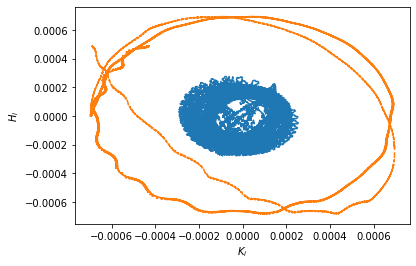

In [524]:
fig,ax = plt.subplots()
for i in range(lsys.N-1):
    line, = ax.plot(nb_results['K'][i], nb_results['H'][i], ls='-')
    ax.plot(sec_soln['K'][i], nb_results['H'][i], ls='--',color=line.get_color())
ax.set_ylabel(r'$H_i$') 
ax.set_xlabel(r'$K_i$') 

In [485]:
Z = get_Z(nb_results, 1, 2, j, k)
Zcom = get_Zcom(nb_results, 1, 2, j, k, sim.particles)

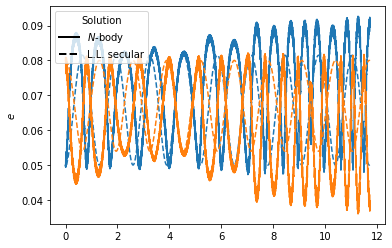

In [531]:
fig,ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
for i in range(lsys.N-1):
    l,=ax.plot(Time ,nb_results['e'][i])
    ax.plot(Time,sec_soln['e'][i],color=l.get_color(),ls='--')  
ax.set_ylabel('$e$')
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k',lw=2, ls='-'),
                Line2D([0], [0], color='k',lw=2, ls='--')]
ax.legend(custom_lines, [r'$N$-body',"L.L. secular"],loc='upper left',title='Solution')

In [13]:
res = sec_soln
ps = sa[0].particles
alpha = ps[1].a/ps[2].a#res['alpha']
f2 = 1/8*(2*alpha*b(0.5, 0, 1, alpha) + alpha**2*b(0.5, 0, 2, alpha))
f10 = 1/4*(2*b(0.5, 1, 0, alpha)-2*alpha*b(0.5, 1, 1, alpha) - alpha**2*b(0.5, 1, 2, alpha))
A = -sim.G*ps[1].m*ps[2].m/a20*np.array([[f2/res['L10'], f10/2/np.sqrt(res['L10']*res['L20'])], [f10/2/np.sqrt(res['L10']*res['L20']), f2/res['L20']]])
A

array([[-2.53977512e-05,  1.91215759e-05],
       [ 1.91215759e-05, -2.13975965e-05]])

In [22]:
1/8*(2*alpha*b(0.5, 0, 1, alpha) + alpha**2*b(0.5, 0, 2, alpha))

In [30]:
1/4*alpha*b(1.5, 1, 0, alpha)

In [28]:
1/4*alpha*b(1.5, 2, 0, alpha)

In [29]:
1/4*(2*b(0.5, 1, 0, alpha)-2*alpha*b(0.5, 1, 1, alpha) - alpha**2*b(0.5, 1, 2, alpha))

In [14]:
lsys.Neccentricity_matrix/2

array([[-2.54108764e-05,  1.91332916e-05],
       [ 1.91332916e-05, -2.14100083e-05]])

In [17]:
vals,T = np.linalg.eigh(A)
D = np.diag(vals)
D

array([[-4.26235671e-05,  0.00000000e+00],
       [ 0.00000000e+00, -4.17178053e-06]])

In [18]:
kappa0 = res['kappa'][:,0]#/res['Lr']**(1/2)
eta0 = res['eta'][:,0]#/res['Lr']**(1/2)

In [19]:
H0 = T.T @ eta0
K0 = T.T @ kappa0

In [20]:
t1 = nb_results['time']#-res['time']*ps[2].n*np.exp(1)
freqs = np.diag(D)
cos_vals = np.array([np.cos(freq * t1) for freq in freqs]).T
sin_vals = np.array([np.sin( freq * t1) for freq in freqs]).T
K = K0 * cos_vals - H0 * sin_vals    
H = K0 * sin_vals + H0 * cos_vals
eta = np.transpose(T @ H.T).T# * res['Lr']**(1/2)
kappa = np.transpose(T @ K.T).T# * res['Lr']**(1/2)

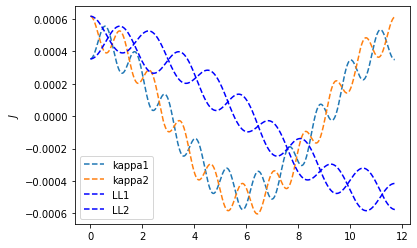

In [21]:
fig,ax = plt.subplots()
Time = res['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
ax.plot(Time,sec_soln['kappa'][0],ls='--', label='kappa1')  
ax.plot(Time,sec_soln['kappa'][1],ls='--', label='kappa2')  
ax.plot(Time,kappa[0],color='b',ls='--', label='LL1')  
ax.plot(Time,kappa[1],color='b',ls='--', label='LL2')  

#ax.plot(Time,sec_soln['J'][0] + sec_soln['J'][1],color='b', label='Sum')  
ax.set_ylabel('$J$')
ax.legend()

In [689]:
lsys.eccentricity_eigenvalues()

array([-8.52960499e-05, -8.34571948e-06])

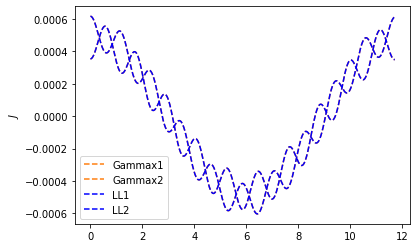

In [665]:
fig,ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
ax.plot(Time,sec_soln['Gammax'][0],color=l.get_color(),ls='--', label='Gammax1')  
ax.plot(Time,sec_soln['Gammax'][1],color=l.get_color(),ls='--', label='Gammax2')  
ax.plot(Time,sec_soln['kappa'][0],color='b',ls='--', label='LL1')  
ax.plot(Time,sec_soln['kappa'][1],color='b',ls='--', label='LL2')  

#ax.plot(Time,sec_soln['J'][0] + sec_soln['J'][1],color='b', label='Sum')  
ax.set_ylabel('$J$')
ax.legend()

In [690]:
D

array([[-4.26235671e-05,  0.00000000e+00],
       [ 0.00000000e+00, -4.17178053e-06]])

In [646]:
res = sec_soln
ps = sa[0].particles
alpha = ps[1].a/ps[2].a#res['alpha']
f2 = 1/8*(2*alpha*b(0.5, 0, 1, alpha) + alpha**2*b(0.5, 0, 2, alpha))
f10 = 1/4*(2*b(0.5, 1, 0, alpha)-2*alpha*b(0.5, 1, 1, alpha) - alpha**2*b(0.5, 1, 2, alpha))
eps = (ps[1].m + alpha**(1/6)*ps[2].m)/ps[0].m
a1 = f2*res['L20']/res['L0']
a2 = f10/2*np.sqrt(res['L10']*res['L20'])/res['L0']
a3 = f2*res['L10']/res['L0']
A = eps*np.array([[a1, a2], [a2, a3]])
A                     

array([[ 3.06017128e-05, -2.30395584e-05],
       [-2.30395584e-05,  2.57819323e-05]])

In [648]:
A = -sim.G*ps[1].m*ps[2].m/a20*np.array([[f2/res['L10'], f10/2/np.sqrt(res['L10']*res['L20'])], [f10/2/np.sqrt(res['L10']*res['L20']), f2/res['L20']]])
A

array([[-2.53977512e-05,  1.91215759e-05],
       [ 1.91215759e-05, -2.13975965e-05]])

In [650]:
vals,T = np.linalg.eigh(A)
D = np.diag(vals)

In [651]:
T.T @ A @ T

array([[-4.26235671e-05,  6.64848888e-22],
       [-2.16441829e-21, -4.17178053e-06]])

In [652]:
X0_vec = res['Gammax'][:,0]#/res['Lr']**(1/2)
Y0_vec = res['Gammay'][:,0]#/res['Lr']**(1/2)

In [653]:
H0 = T.T @ Y0_vec
K0 = T.T @ X0_vec

In [663]:
t1 = res['time']#-res['time']*ps[2].n*np.exp(1)
freqs = np.diag(D)
cos_vals = np.array([np.cos(freq * t1) for freq in freqs]).T
sin_vals = np.array([np.sin( freq * t1) for freq in freqs]).T
K = K0 * cos_vals - H0 * sin_vals    
H = K0 * sin_vals + H0 * cos_vals
YLL = np.transpose(T @ H.T).T# * res['Lr']**(1/2)
XLL = np.transpose(T @ K.T).T# * res['Lr']**(1/2)

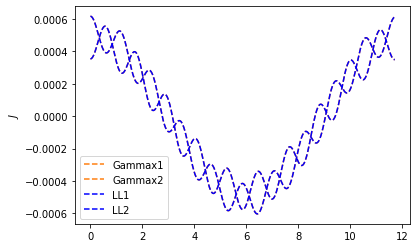

In [665]:
fig,ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
ax.plot(Time,sec_soln['Gammax'][0],color=l.get_color(),ls='--', label='Gammax1')  
ax.plot(Time,sec_soln['Gammax'][1],color=l.get_color(),ls='--', label='Gammax2')  
ax.plot(Time,sec_soln['kappa'][0],color='b',ls='--', label='LL1')  
ax.plot(Time,sec_soln['kappa'][1],color='b',ls='--', label='LL2')  

#ax.plot(Time,sec_soln['J'][0] + sec_soln['J'][1],color='b', label='Sum')  
ax.set_ylabel('$J$')
ax.legend()

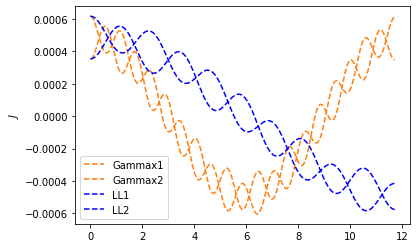

In [664]:
fig,ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
ax.plot(Time,sec_soln['Gammax'][0],color=l.get_color(),ls='--', label='Gammax1')  
ax.plot(Time,sec_soln['Gammax'][1],color=l.get_color(),ls='--', label='Gammax2')  
ax.plot(Time,XLL[0],color='b',ls='--', label='LL1')  
ax.plot(Time,XLL[1],color='b',ls='--', label='LL2')  

#ax.plot(Time,sec_soln['J'][0] + sec_soln['J'][1],color='b', label='Sum')  
ax.set_ylabel('$J$')
ax.legend()

# I'm off by a factor of sqrt 2 somewhere

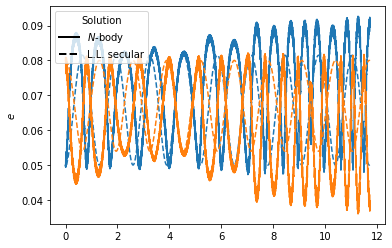

In [317]:
fig,ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
for i in range(lsys.N-1):
    l,=ax.plot(Time ,nb_results['e'][i])
    ax.plot(Time,sec_soln['e'][i],color=l.get_color(),ls='--')  
ax.set_ylabel('$e$')
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k',lw=2, ls='-'),
                Line2D([0], [0], color='k',lw=2, ls='--')]
ax.legend(custom_lines, [r'$N$-body',"L.L. secular"],loc='upper left',title='Solution')

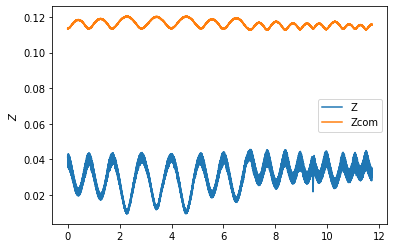

In [319]:
fig,ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
l,=ax.plot(Time,e, label='Z')
#ax.plot(Time, np.sqrt(2)*Znew, label='Znew')
l,=ax.plot(Time ,ecom, label='Zcom')
ax.set_ylabel('$Z$')
ax.legend()

X=kappa and Y=eta

In [536]:
ps = sa[0].particles
alpha = ps[1].a/ps[2].a
f = -np.sqrt((ps[i].m+ps[2].m)/ps[1].m/np.sqrt(alpha))
g = np.sqrt((ps[i].m+ps[2].m)/ps[2].m)
f2 = 1/8*(2*alpha*b(0.5, 0, 1, alpha) + alpha**2*b(0.5, 0, 2, alpha))
f10 = 1/4*(2*b(0.5, 1, 0, alpha)-2*alpha*b(0.5, 1, 1, alpha) - alpha**2*b(0.5, 1, 2, alpha))
prefac = 2*(ps[1].m+ps[2].m)/(f**2 + g**2)
as2 = 2 * prefac *(f2*(f**2/ps[1].m/np.sqrt(alpha) + g**2/ps[2].m) + f10*f*g/np.sqrt(ps[2].m*ps[1].m*np.sqrt(alpha)))
bs2 = 2 * prefac*f10*(f**2/ps[1].m/np.sqrt(alpha) - g**2/ps[2].m)
cs = prefac * (f2*(f**2/ps[1].m/np.sqrt(alpha) + g**2/ps[2].m) - f10*(f*g/np.sqrt(ps[1].m*ps[2].m*np.sqrt(alpha))))
eps = ps[1].m*ps[2].m/ps[0].m/(ps[1].m+ps[2].m)
A = np.array([[as2, cs], [cs, bs2]])*eps
A                     

array([[ 6.43088810e-05,  8.71766692e-06],
       [ 8.71766692e-06, -1.64054063e-05]])

$\begin{bmatrix}
    a_s       & c_s \\
    c_s       & b_s \\
\end{bmatrix}$

$a_3$

In [591]:

ps = sa[0].particles
alpha = ps[1].a/ps[2].a
print(alpha)
f2 = 1/8*(2*alpha*b(0.5, 0, 1, alpha) + alpha**2*b(0.5, 0, 2, alpha))
f10 = 1/4*(2*b(0.5, 1, 0, alpha)-2*alpha*b(0.5, 1, 1, alpha) - alpha**2*b(0.5, 1, 2, alpha))
as2 = 2*(f2*((L10**2 + L20**2)/L0**2) + f10*L10*L20/L0**2)
bs2 = 2*(f2*L10*L20/L0**2 - f10*L10*L20/L0**2)
cs = np.sqrt(L10*L20)/L0*(f2*(L10-L20)/L0 + f10/2*(L20-L10/L0))
mu = (ps[1].m + alpha**(-1/2)*ps[2].m)/ps[0].m
A = np.array([[as2, cs], [cs, bs2]])*mu*2
A                     

0.5033700919195077


array([[1.74355779e-05, 1.60814327e-06],
       [1.60814327e-06, 4.27253885e-05]])

In [592]:
vals,T = np.linalg.eigh(A)
D = np.diag(vals)

In [593]:
T.T @ A @ T

array([[ 1.73337285e-05, -1.16914558e-22],
       [ 6.63723041e-23,  4.28272379e-05]])

In [630]:
X0_vec = Y[:,0]
Y0_vec = X[:,0]

In [631]:
H0 = T.T @ Y0_vec
K0 = T.T @ X0_vec

In [632]:
t1 = -nb_results['time']*ps[2].n
freqs = np.diag(D)
cos_vals = np.array([np.cos(freq * t1) for freq in freqs]).T
sin_vals = np.array([np.sin( freq * t1) for freq in freqs]).T
K = K0 * cos_vals - H0 * sin_vals    
H = K0 * sin_vals + H0 * cos_vals
YLL = np.transpose(T @ H.T).T
XLL = np.transpose(T @ K.T).T

In [633]:
K.T[0]

array([-6.63868319e-05, -6.54877317e-05, -6.45853401e-05, ...,
        1.41847316e-04,  1.41968820e-04,  1.42083161e-04])

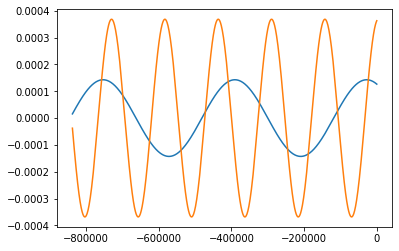

In [634]:
fig, ax = plt.subplots()
ax.plot(t1, H)

In [635]:
XLL

array([[ 7.02844864e-05,  6.97883937e-05,  6.92876566e-05, ...,
        -1.64637071e-04, -1.64810677e-04, -1.64970030e-04],
       [ 5.94415771e-05,  6.58332781e-05,  7.22037190e-05, ...,
        -3.55349805e-04, -3.56168635e-04, -3.56875727e-04]])

In [636]:
Zpred = np.sqrt(XLL[0]**2 + YLL[0]**2)*np.sqrt(L0/L10/L20)
Zpred

array([0.03140153, 0.03144429, 0.03148756, ..., 0.04168057, 0.04168102,
       0.04168091])

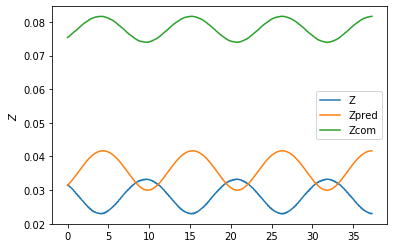

In [637]:
fig,ax = plt.subplots()
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
l,=ax.plot(Time ,Z, label='Z')
ax.plot(Time, Zpred, label='Zpred')
l,=ax.plot(Time ,Zcom, label='Zcom')
ax.set_ylabel('$Z$')
ax.legend()

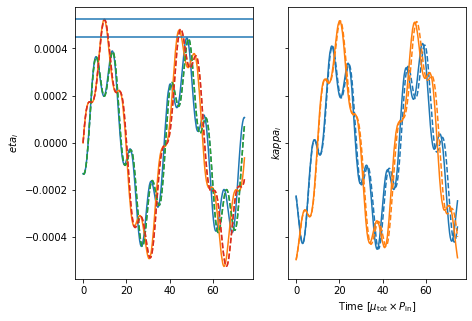

In [297]:
fig,ax = plt.subplots(1,2,sharey='row',figsize=(7,5))
for l,pair in enumerate([('eta','kappa')]):
    for m,var in enumerate(pair):
        for i in range(lsys.N-1):
            line, = ax[m].plot(Time,nb_results[var][i],ls='-')
            ax[m].plot(Time,sec_soln[var][i],ls='--',color=line.get_color())
        ax[m].set_ylabel(r'${}_i$'.format(var));    
for i, e in enumerate(eta.T):
    ax[0].plot(Time, e, '--')
    ax[0].axhline(etamax[i])
ax[1].set_xlabel(r'Time [$\mu_\mathrm{tot} \times P_\mathrm{in} $]');
ax[1].set_xlabel(r'Time [$\mu_\mathrm{tot} \times P_\mathrm{in} $]');

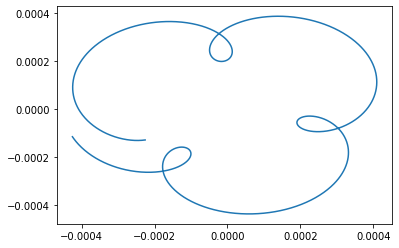

In [515]:
fig,ax = plt.subplots()
ax.plot(sec_soln['kappa'][0], sec_soln['eta'][0],ls='-')


In [384]:
A = lsys.Neccentricity_matrix

In [385]:
vals,T = np.linalg.eigh(A)
D = np.diag(vals)

In [386]:
T.T @ A @ T

array([[-7.23240726e-05,  1.69371998e-21],
       [-2.91205504e-21, -1.68343351e-05]])

In [387]:
H0 = T.T @ lsys.eta0_vec
K0 = T.T @ lsys.kappa0_vec

In [393]:
H0, K0

(array([1.03527524e-04, 7.84094922e-05]), array([-0.00011824,  0.00053074]))

way to calculate h(t), k(t), calculate H0, K0, calculate H(t), K(t), rotate back to h(t), k(t) with T

In [395]:
S = np.sqrt(K0**2 + H0**2)
etamax = np.abs(T) @ S.T
etamax

array([0.00015716, 0.0005365 ])

In [397]:
etamax = np.abs(T) @ S.T
etamax

array([0.00044884, 0.00052278])

In [399]:
t1 = nb_results['time']
freqs = np.diag(D)
cos_vals = np.array([np.cos(freq * t1) for freq in freqs]).T
sin_vals = np.array([np.sin( freq * t1) for freq in freqs]).T
K = K0 * cos_vals - H0 * sin_vals    
H = K0 * sin_vals + H0 * cos_vals
eta = np.transpose(T @ H.T) 
kappa = np.transpose(T @ K.T) 

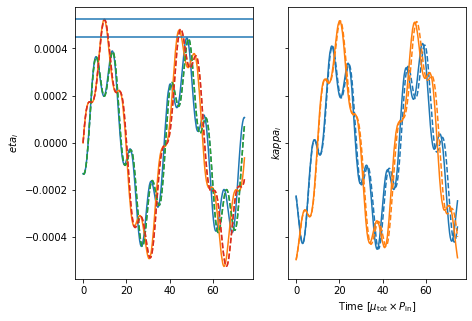

In [297]:
fig,ax = plt.subplots(1,2,sharey='row',figsize=(7,5))
for l,pair in enumerate([('eta','kappa')]):
    for m,var in enumerate(pair):
        for i in range(lsys.N-1):
            line, = ax[m].plot(Time,nb_results[var][i],ls='-')
            ax[m].plot(Time,sec_soln[var][i],ls='--',color=line.get_color())
        ax[m].set_ylabel(r'${}_i$'.format(var));    
for i, e in enumerate(eta.T):
    ax[0].plot(Time, e, '--')
    ax[0].axhline(etamax[i])
ax[1].set_xlabel(r'Time [$\mu_\mathrm{tot} \times P_\mathrm{in} $]');
ax[1].set_xlabel(r'Time [$\mu_\mathrm{tot} \times P_\mathrm{in} $]');

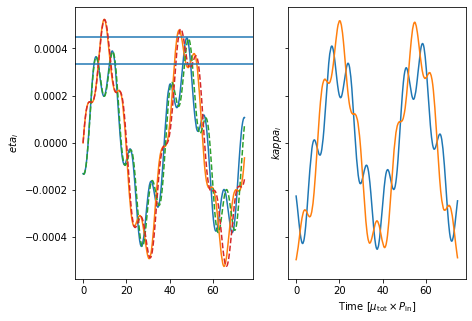

In [284]:
fig,ax = plt.subplots(1,2,sharey='row',figsize=(7,5))
for l,pair in enumerate([('eta','kappa')]):
    for m,var in enumerate(pair):
        for i in range(lsys.N-1):
            line, = ax[m].plot(Time,nb_results[var][i],ls='-')
            #ax[m].plot(Time,eta[i],ls='--',color=line.get_color())
        ax[m].set_ylabel(r'${}_i$'.format(var));    
for i, e in enumerate(eta.T):
    ax[0].plot(Time, e, '--')
    ax[0].axhline(etamax[i])
ax[1].set_xlabel(r'Time [$\mu_\mathrm{tot} \times P_\mathrm{in} $]');
ax[1].set_xlabel(r'Time [$\mu_\mathrm{tot} \times P_\mathrm{in} $]');

In [179]:
lsys.eta0_vec

array([-1.29869077e-04, -1.40066129e-07])

In [185]:
Xre = kappa / np.sqrt([p.Lambda for p in self.particles[1:]])
Xim = -eta / np.sqrt([p.Lambda for p in self.particles[1:]])
Xtoz = np.sqrt(1 - 0.25 * (Xre**2 + Xim**2))
zre = Xre * Xtoz 
zim = Xim * Xtoz 
solution = {
        "time":times,
        "H":H,
        "K":K,
        "eta":eta,
        "kappa":kappa,
        "k":zre,
        "h":zim,
        "z":zre + 1j * zim, 
        "e":np.sqrt(zre*zre + zim*zim),
        "pomega":np.arctan2(zim,zre)
        }    
return {key:val.T for key,val in solution.items()}

NameError: name 'self' is not defined

# Make plots of Z and Zcom vs time

Write out the laplace-lagrange matrix and solve eigenmodes in terms of as, bs, cs

# Applying correction to Laplace-Lagrange theory from first-order MMRs
The secular dynamics of a planetary systems can be significantly altered if any pairs of planets are close to a $k$:$k-1$ first-order mean motion resonance. The secular terms in the equations arising from the influence of a first-order MMR are second order in the planet-star mass ratios (${\cal O}(\mu^2)$), but can be comparable to or larger than the ${\cal O}(\mu)$ terms due to the presence of a small resonant denominator. In particular, the dominant secular contribution of a first-order resonance is $ \propto \frac{k^2 \mu^2 n'}{kn' - (k-1)n}$, which can be significant close to resonance. The `LaplaceLagrangeSystem` class provides the `add_first_order_resonance_term` and `add_first_order_resonance_terms` mehtods to include corrections to the secular equations of motion arising from a first-order MMR. The example below demonstrates how these methods are used and compares the accuracy of the `LaplaceLagrangeSystem` to $N$-body with and without this correction.

In [8]:
def get_sim(pratio):
    sim = rb.Simulation()
    sim.add(m=1)
    sim.add(m = 3e-5, P = 1 ,e = 0.01, inc = 0.01, pomega = 0)
    sim.add(m = 3e-5, P = pratio ,e = 0.01, pomega = np.pi/2)
    sim.integrator = 'whfast'
    sim.ri_whfast.safe_mode = 0 
    set_timestep(sim,1/27.)    
    sim.move_to_com()
    align_simulation(sim)
    return sim



### Set resonance

In [9]:
kres = 3

### Set up simulation near resonance
 Set $P_2 = \frac{k_\mathrm{res}}{k_\mathrm{res}-1}P_1(1+\Delta_0)$

In [10]:
Delta0 = 0.02
sim = get_sim(kres * (1 + 0.02) / (kres - 1))
llsys = LaplaceLagrangeSystem.from_Simulation(sim)
Tmax = 4 * np.max( 2 * np.pi / np.abs(llsys.eccentricity_eigenvalues()) ) 

### $\pmb{S}_e$ Matrix without resonance correction

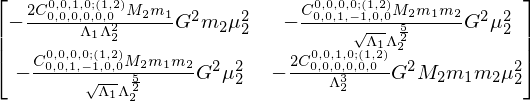

In [11]:
llsys.eccentricity_matrix

In [12]:
llsys.Neccentricity_matrix

array([[-0.00029768,  0.00023825],
       [ 0.00023825, -0.00025834]])

### $\pmb{S}_e$ Matrix with resonance correction

In [13]:
from sympy import S
from celmech.disturbing_function import get_DFCoeff_symbol

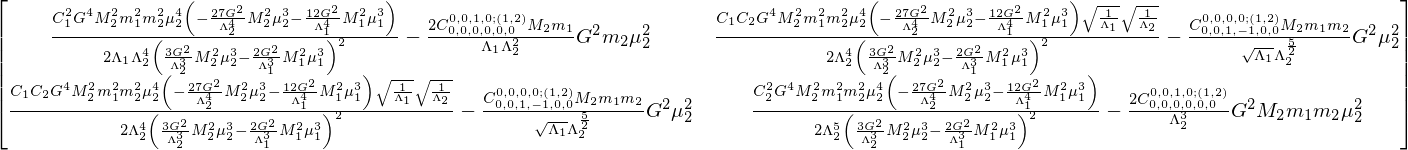

In [14]:
llsys.add_first_order_resonance_term(1,2,kres)
# Using substitution {Cin:S('C1'),Cout:S('C2')} to make result more legible
Cin = get_DFCoeff_symbol(kres,1-kres,-1,0,0,0,0,0,0,0,1,2)
Cout = get_DFCoeff_symbol(kres,1-kres,0,-1,0,0,0,0,0,0,1,2)
llsys.eccentricity_matrix.subs({Cin:S('C1'),Cout:S('C2')})

In [15]:
llsys.Neccentricity_matrix

array([[-0.00040232,  0.00035937],
       [ 0.00035937, -0.00039854]])

## Compare Laplace-Lagrange theory with and without correction to $N$-body

A secular system consisting of two planets has three non-trivial secular frequencies (two eccentricity modes and one inclination mode).  

The example below computes secular frequencies using `frequency_modified_fourier_transform` for a series of $N$-body simulations near the $k_\mathrm{res}$:$k_\mathrm{res}-1$ resonance and compares the numerically-determined frequencies to frequencies computed using Laplace-Lagrange theory with and without the resonant correction.

In [16]:
# Define a function to get secular frequencies out of a simulation archive
from celmech.miscellaneous import frequency_modified_fourier_transform
def get_Nbody_freqs(sa):
    nb_results = get_simarchive_integration_results(sa)
    nb_results['z'] = nb_results['e'] * np.exp(+1j * nb_results['pomega'])
    z = nb_results['z'][0]
    nb_results['zeta'] = np.sin(nb_results['inc'] /2) * np.exp(+1j * nb_results['Omega'])
    zeta = nb_results['zeta'][0]
    ecc_fmft_result = frequency_modified_fourier_transform(
        nb_results['time'],
        z,
        2
    )
    inc_fmft_result = frequency_modified_fourier_transform(
        nb_results['time'],
        zeta,
        1
    )
    return np.array(list(ecc_fmft_result.keys()) + list(inc_fmft_result.keys()))

In [17]:
# Set range of periods and number of simulations to run.
DeltaMin = 0
DeltaMax = 0.04
Nsim = 11
periods = ( kres / (kres-1) ) * (1 +  np.linspace(DeltaMin,DeltaMax,Nsim) )

In [18]:
# Set integration time to 4x the estimated secular timescale.
sim=get_sim(np.max(periods))
llsys = LaplaceLagrangeSystem.from_Simulation(sim)
Tmax = 4 * np.max( 2 * np.pi / np.abs(llsys.eccentricity_eigenvalues()) ) 

In [19]:
# Run integrations and get secular frequencies.
freqsNbody = {}
freqsAnalytic_NoCorrection = {}
freqsAnalytic_Corrected = {}

for i,p in enumerate(periods):
    file='sim_inc_{}.bin'.format(i)
    if not isfile(file):
        sim.automateSimulationArchive(file,interval = Tmax / 1024 ,deletefile=True)
        sim.integrate(Tmax)
    sa = rb.SimulationArchive(file)
    sim = sa[0]
    llsys = LaplaceLagrangeSystem.from_Simulation(sim)
    
    valsN = get_Nbody_freqs(sa)
    vals = np.append(
        llsys.eccentricity_eigenvalues(),
        llsys.inclination_eigenvalues()[1]
    )
    llsys.add_first_order_resonance_term(1,2,3)
    vals_corr = np.append(
        llsys.eccentricity_eigenvalues(),
        llsys.inclination_eigenvalues()[1]
    )
    freqsNbody.update({p:valsN})
    freqsAnalytic_NoCorrection.update({p:vals})
    freqsAnalytic_Corrected.update({p:vals_corr})
        

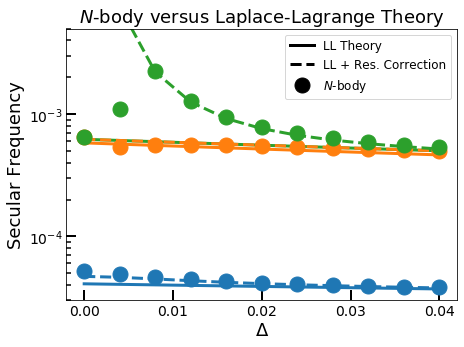

In [20]:
# Plot the results.

Delta = 2*periods/3-1
y1 = np.array([
    np.sort(np.abs(freqsAnalytic_NoCorrection[p]))
    for p in periods
])
y2 = np.array([
    np.sort(np.abs(freqsAnalytic_Corrected[p]))
    for p in periods
])
y3 = np.array([
    np.sort(np.abs(freqsNbody[p]))
    for p in periods
])

plt.figure(figsize=(7,5))
plt.yscale('log')
plt.ylim(3e-5,0.5e-2)
plt.xticks(np.linspace(0.0,0.04,5))
plt.title("$N$-body versus Laplace-Lagrange Theory",fontsize=18)
plt.ylabel("Secular Frequency",fontsize = 18)
plt.xlabel(r"$\Delta$",fontsize = 18)
plt.tick_params(labelsize=14,direction='in',width = 1.5,size=5, which='both')
plt.tick_params(size=10, width=2, which='major')
for i in range(3):
    l,=plt.plot(Delta,y1[:,i],lw=3,zorder=1)
    l,=plt.plot(Delta,y2[:,i],color=l.get_color(),ls='--',lw=3,zorder=2)
    l,=plt.plot(Delta,y3[:,i],'o',color=l.get_color(),zorder=3,ms=15)

from matplotlib.lines import Line2D
custom_lines=[
    Line2D([0],[0],color='k',ls='-',lw=3),
    Line2D([0],[0],color='k',ls='--',lw=3),
    Line2D([0],[0],color='k',marker='o',lw=0,ms=15)
]
plt.legend(custom_lines,['LL Theory','LL + Res. Correction',r'$N$-body'],prop={'size': 12})
    